In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                                
import seaborn as sns                                          
from sklearn.model_selection import train_test_split           
from sklearn.neighbors import KNeighborsClassifier              
from sklearn.feature_selection import VarianceThreshold         
from sklearn.pipeline import Pipeline                         
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV              
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("dataset/A_E_Fire_Dataset.csv")
df.shape

(17442, 7)

In [3]:
df.head()

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1


In [4]:
# The data matrix X
X = df.iloc[:, :-1]
# The labels
y = (df.iloc[:,-1:])

X.shape, y.shape

((17442, 6), (17442, 1))

In [5]:
# Unique values in FUEL column
X['FUEL'].value_counts()

FUEL
gasoline    5130
thinner     5130
kerosene    5130
lpg         2052
Name: count, dtype: int64

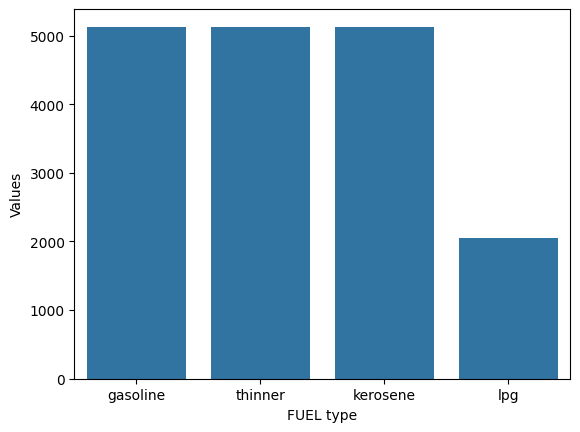

In [6]:
# Plot unique values in FUEL column
uniques = X['FUEL'].value_counts()
sns.barplot(x = uniques.index, y = uniques.values)
plt.xlabel("FUEL type")
plt.ylabel("Values")
plt.show()

In [7]:
# Ordinal encode input variable
ordinal = OrdinalEncoder()
X['FUEL'] = ordinal.fit_transform(X[['FUEL']])

In [8]:
X['FUEL'].unique()

array([0., 3., 1., 2.])

In [9]:
X.tail(110)

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY
17332,7,2.0,170,78,1.4,2
17333,7,2.0,170,76,0.0,1
17334,7,2.0,180,104,0.0,75
17335,7,2.0,180,97,0.0,72
17336,7,2.0,180,96,0.0,70
...,...,...,...,...,...,...
17437,7,2.0,190,86,2.2,5
17438,7,2.0,190,84,2.0,4
17439,7,2.0,190,80,1.5,3
17440,7,2.0,190,76,0.4,2


In [10]:
X.head()

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY
0,1,0.0,10,96,0.0,75
1,1,0.0,10,96,0.0,72
2,1,0.0,10,96,2.6,70
3,1,0.0,10,96,3.2,68
4,1,0.0,10,109,4.5,67


In [11]:
y

,STATUS
0,0
1,1
2,1
3,1
4,1
...,...
17437,0
17438,0
17439,0
17440,0


In [12]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,                  # predictors
                                                    y,                  # labels
                                                    test_size=1/3,      # test set size
                                                    random_state=0)     # set random number generator seed for reproducibility

print(X_train.shape)
print(X_test.shape)

(11628, 6)
(5814, 6)


In [13]:
# Instantiate KNN classifier and fit on train set
knn = KNeighborsClassifier().fit(X_train, y_train)

# Performance on train and test sets
print('Training set score: ' + str(round(knn.score(X_train,y_train)*100,2))+"%")
print('Test set score: ' + str(round(knn.score(X_test,y_test)*100,2))+"%")

Training set score: 94.26%
Test set score: 91.61%


In [14]:
# Setup pipeline
pipe = Pipeline([('scaler', StandardScaler()),
                 ('selector', VarianceThreshold()),
                 ('classifier', KNeighborsClassifier())
                 ])

In [15]:
# Fit pipeline on train set
pipe.fit(X_train, y_train)


# Performance on train and test sets
print('Training set score: ' + str(round(pipe.score(X_train,y_train)*100,2))+"%")
print('Test set score: ' + str(round(pipe.score(X_test,y_test)*100,2))+"%")

Training set score: 97.65%
Test set score: 96.13%


In [16]:
parameters = {'scaler': [StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()],
              'selector__threshold': [0, 0.001, 0.01],
			  'classifier__n_neighbors': [1, 3, 5, 7, 10],           # Number of neighbors to use by default for k-neighbors
			  'classifier__p': [1, 2],                               # Power parameter for the Minkowski metric
			  'classifier__leaf_size': [1, 5, 10, 15]                # Leaf size passed to BallTree or KDTree. This can affect the speed of the
			  }                                                      # construction and query, as well as the memory required to store the tree

In [17]:
# Instantiate GridSearchCV
grid = GridSearchCV(pipe, parameters, cv=2).fit(X_train, y_train)

# Performance on train and test sets
print('Training set score: ' + str(round(grid.score(X_train,y_train)*100,2))+"%")
print('Test set score: ' + str(round(grid.score(X_test,y_test)*100,2))+"%")

Training set score: 98.0%
Test set score: 96.85%


In [18]:
# Access the best set of parameters
best_params = grid.best_params_
print(best_params)

# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

{'classifier__leaf_size': 15, 'classifier__n_neighbors': 5, 'classifier__p': 1, 'scaler': MaxAbsScaler(), 'selector__threshold': 0}
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('selector', VarianceThreshold(threshold=0)),
                ('classifier', KNeighborsClassifier(leaf_size=15, p=1))])


In [19]:
# Create a dataframe
result_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')
print(result_df.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__leaf_size', 'param_classifier__n_neighbors',
       'param_classifier__p', 'param_scaler', 'param_selector__threshold',
       'params', 'split0_test_score', 'split1_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')


In [20]:
result_df.shape

(480, 15)

In [21]:
result_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__leaf_size,param_classifier__n_neighbors,param_classifier__p,param_scaler,param_selector__threshold,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.076111,0.012577,1.540887,0.199390,1,1,1,StandardScaler(),0.000,"{'classifier__leaf_size': 1, 'classifier__n_ne...",0.946508,0.947196,0.946852,0.000344,343
1,0.056764,0.006572,1.600760,0.201161,1,1,1,StandardScaler(),0.001,"{'classifier__leaf_size': 1, 'classifier__n_ne...",0.946508,0.947196,0.946852,0.000344,343
2,0.138359,0.010414,1.831340,0.212370,1,1,1,StandardScaler(),0.010,"{'classifier__leaf_size': 1, 'classifier__n_ne...",0.946508,0.947196,0.946852,0.000344,343
3,0.110540,0.013072,1.655822,0.399015,1,1,1,MinMaxScaler(),0.000,"{'classifier__leaf_size': 1, 'classifier__n_ne...",0.949776,0.951840,0.950808,0.001032,205
4,0.080777,0.008838,1.174331,0.085755,1,1,1,MinMaxScaler(),0.001,"{'classifier__leaf_size': 1, 'classifier__n_ne...",0.949776,0.951840,0.950808,0.001032,205


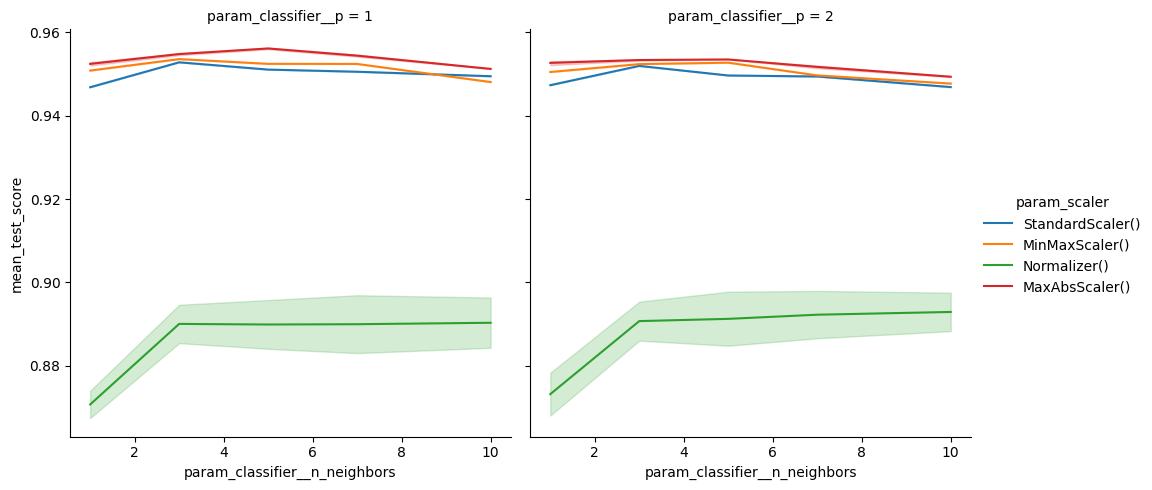

In [22]:
# Let’s see how `n_neighbors` affect the performance for different `scalers`, and for different values of `p`.

sns.relplot(data = result_df,
            kind = 'line',
			x = 'param_classifier__n_neighbors',
			y = 'mean_test_score',
			hue = 'param_scaler',
			col = 'param_classifier__p')
plt.show()

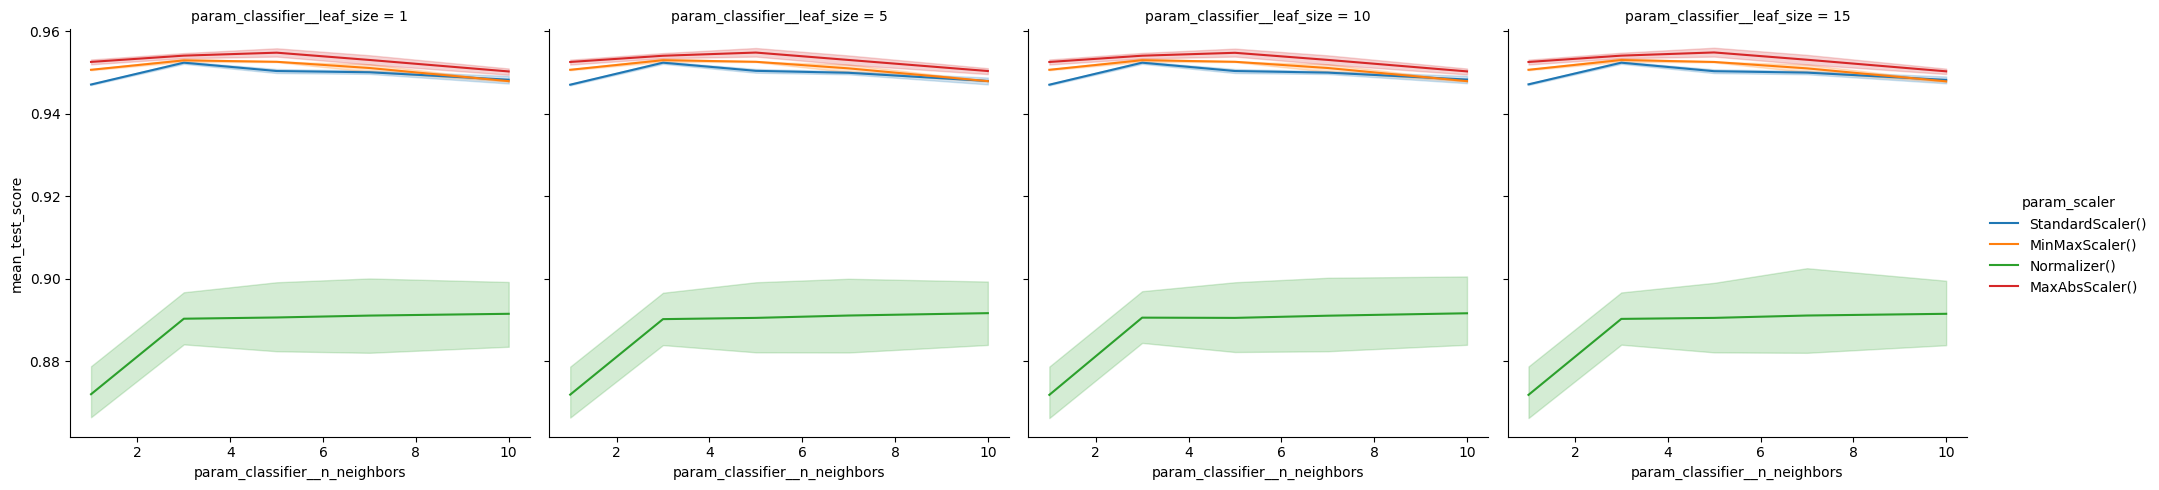

In [23]:
#  Let’s see how n_neighbors affect the performance for different scalers, and for different values of leaf_size.
sns.relplot(data = result_df,
            kind = 'line',
            x = 'param_classifier__n_neighbors',
            y = 'mean_test_score',
            hue = 'param_scaler',
            col = 'param_classifier__leaf_size')
plt.show()

In [24]:
import joblib
joblib.dump(knn,"KNN_model.pkl")

['KNN_model.pkl']

In [25]:
import numpy as np
from joblib import load

# Load the trained model
model = load("KNN_model.pkl")

print("🔥 Acoustic Fire Extinguisher Manual Testing 🔥")
print("Enter the following details:")

# Manual user inputs
SIZE = float(input("Flame Size (e.g., 3.0): "))
FUEL = input("Fuel Type (Gasoline, Thinner, Kerosene, LPG): ").strip().capitalize()
DISTANCE = float(input("Distance from flame (cm): "))
DESIBEL = float(input("Sound intensity (dB): "))
AIRFLOW = float(input("Airflow (m/s): "))
FREQUENCY = float(input("Sound frequency (Hz): "))

# Fuel encoding used during training
fuel_encoding = {
    'Gasoline': 0,
    'Thinner': 1,
    'Kerosene': 2,
    'LPG': 3
}
FUEL_ENCODED = fuel_encoding.get(FUEL, -1)

if FUEL_ENCODED == -1:
    print("❌ Invalid fuel type. Please enter one of:", list(fuel_encoding.keys()))
else:
    test_input = np.array([[SIZE, FUEL_ENCODED, DISTANCE, DESIBEL, AIRFLOW, FREQUENCY]])
    prediction = model.predict(test_input)
    print("✅ RESULT:", "🔥 Fire extinguished!" if prediction[0] == 1 else "❌ Fire NOT extinguished!")


🔥 Acoustic Fire Extinguisher Manual Testing 🔥
Enter the following details:


Flame Size (e.g., 3.0):  1
Fuel Type (Gasoline, Thinner, Kerosene, LPG):  gasoline
Distance from flame (cm):  10
Sound intensity (dB):  96
Airflow (m/s):  0
Sound frequency (Hz):  75


✅ RESULT: ❌ Fire NOT extinguished!


In [27]:
import numpy as np
from joblib import load

# Load the trained model
model = load("KNN_model.pkl")

print("🔥 Acoustic Fire Extinguisher Manual Testing 🔥")
print("Enter the following details:")

# Manual user inputs
SIZE = float(input("Flame Size (e.g., 3.0): "))
FUEL = input("Fuel Type (Gasoline, Thinner, Kerosene, LPG): ").strip().capitalize()
DISTANCE = float(input("Distance from flame (cm): "))
DESIBEL = float(input("Sound intensity (dB): "))
AIRFLOW = float(input("Airflow (m/s): "))
FREQUENCY = float(input("Sound frequency (Hz): "))

# Fuel encoding used during training
fuel_encoding = {
    'Gasoline': 0,
    'Thinner': 1,
    'Kerosene': 2,
    'LPG': 3
}
FUEL_ENCODED = fuel_encoding.get(FUEL, -1)

if FUEL_ENCODED == -1:
    print("❌ Invalid fuel type. Please enter one of:", list(fuel_encoding.keys()))
else:
    test_input = np.array([[SIZE, FUEL_ENCODED, DISTANCE, DESIBEL, AIRFLOW, FREQUENCY]])
    prediction = model.predict(test_input)
    print("✅ RESULT:", "🔥 Fire extinguished!" if prediction[0] == 1 else "❌ Fire NOT extinguished!")


🔥 Acoustic Fire Extinguisher Manual Testing 🔥
Enter the following details:


Flame Size (e.g., 3.0):  1
Fuel Type (Gasoline, Thinner, Kerosene, LPG):  gasoline
Distance from flame (cm):  10
Sound intensity (dB):  96
Airflow (m/s):  0
Sound frequency (Hz):  72


✅ RESULT: ❌ Fire NOT extinguished!


In [28]:
import numpy as np
from joblib import load

# Load the trained model
model = load("KNN_model.pkl")

print("🔥 Acoustic Fire Extinguisher Manual Testing 🔥")
print("Enter the following details:")

# Manual user inputs
SIZE = float(input("Flame Size (e.g., 3.0): "))
FUEL = input("Fuel Type (Gasoline, Thinner, Kerosene, LPG): ").strip().capitalize()
DISTANCE = float(input("Distance from flame (cm): "))
DESIBEL = float(input("Sound intensity (dB): "))
AIRFLOW = float(input("Airflow (m/s): "))
FREQUENCY = float(input("Sound frequency (Hz): "))

# Fuel encoding used during training
fuel_encoding = {
    'Gasoline': 0,
    'Thinner': 1,
    'Kerosene': 2,
    'LPG': 3
}
FUEL_ENCODED = fuel_encoding.get(FUEL, -1)

if FUEL_ENCODED == -1:
    print("❌ Invalid fuel type. Please enter one of:", list(fuel_encoding.keys()))
else:
    test_input = np.array([[SIZE, FUEL_ENCODED, DISTANCE, DESIBEL, AIRFLOW, FREQUENCY]])
    prediction = model.predict(test_input)
    print("✅ RESULT:", "🔥 Fire extinguished!" if prediction[0] == 1 else "❌ Fire NOT extinguished!")


🔥 Acoustic Fire Extinguisher Manual Testing 🔥
Enter the following details:


Flame Size (e.g., 3.0):  1
Fuel Type (Gasoline, Thinner, Kerosene, LPG):  gasoline
Distance from flame (cm):  10
Sound intensity (dB):  96
Airflow (m/s):  2.6
Sound frequency (Hz):  70


✅ RESULT: 🔥 Fire extinguished!
